# CAPROT Analysis

Last edit date: 20260202  
Author: Jiawen Liang  
Project: CAPROT

### 0. 加载包

In [341]:
import os
import pandas as pd
import numpy as np
import pymysql
import logging
from datetime import date, datetime, timedelta
import traceback
import time
from typing import Union, List, Dict
import sys
import matplotlib.pyplot as plt

检查当前notebook的工作目录

In [342]:
print("当前工作目录:", os.getcwd())

当前工作目录: d:\jinfuziquant\src\caprot


### 1. 参数预设

In [343]:
# 数据文件路径
DATA_DIR = 'D:/jinfuziquant/data/caprot_data/merged_data_caprot.csv'

# 结果输出路径
OUTPUT_DIR = './results/caprot_output/'

# 回测时间
START_DATE = '2023-01-01'
END_DATE = '2099-12-31'

# 因子参数
STD_WINDOW = 126  # 核心周期：半年趋势 (需要调小一点)
RANK_WINDOW = 60  # 灵敏度：一季度自适应
SMOOTH_WINDOW = 5  # 平滑窗口

# 线性调仓阈值 逻辑：因子稍微偏离中枢，立即介入并锁定趋势
LINEAR_HIGH = 0.70  # Rank > 0.7 开始减仓
LINEAR_LOW = 0.30  # Rank < 0.3 开始加仓

# 标配区
NEUTRAL_L = 0.40
NEUTRAL_H = 0.60

# 单边棘轮
ENABLE_RATCHET = True

# 交易成本
COST = 0.0002
SLIPPAGE = 0.0003

# 全局绘图设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

### 1. 加载数据

In [344]:
def load_data(file_path: str) -> pd.DataFrame: # 指定返回值类型是DataFrame
    """
    加载数据文件，支持CSV和Excel格式
    :param file_path: 文件路径
    :return: 数据框
    """
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        print(f"数据加载成功，文件类型为CSV，数据形状: {df.shape}")
    elif file_path.endswith('.xlsx') or file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
        print(f"数据加载成功，文件类型为Excel，数据形状: {df.shape}")
    else:
        raise ValueError("加载失败，文件格式不支持")
    return df

df = load_data(DATA_DIR)

数据加载成功，文件类型为CSV，数据形状: (1237, 55)


### 3. 修改表头，简化名称

In [345]:
# 列名映射字典
rename_map = {
    'TradingDay': 'date',
    'idx_000905_SH__index_code': 'zz500_code',
    'idx_000905_SH__prev_close': 'zz500_prev_close',
    'idx_000905_SH__open_price': 'zz500_open',
    'idx_000905_SH__high_price': 'zz500_high',
    'idx_000905_SH__low_price': 'zz500_low',
    'idx_000905_SH__close_price': 'zz500_close',
    'idx_000905_SH__turnover_volume': 'zz500_vol',
    'idx_000905_SH__turnover_value': 'zz500_amt',
    'idx_000905_SH__change_pct': 'zz500_chg_pct',
    'idx_000905_SH__negotiable_mv': 'zz500_mv',
    'idx_000905_SH__index_return': 'zz500_ret',
    
    'idx_000300_SH__index_code': 'hs300_code',
    'idx_000300_SH__prev_close': 'hs300_prev_close',
    'idx_000300_SH__open_price': 'hs300_open',
    'idx_000300_SH__high_price': 'hs300_high',
    'idx_000300_SH__low_price': 'hs300_low',
    'idx_000300_SH__close_price': 'hs300_close',
    'idx_000300_SH__turnover_volume': 'hs300_vol',
    'idx_000300_SH__turnover_value': 'hs300_amt',
    'idx_000300_SH__change_pct': 'hs300_chg_pct',
    'idx_000300_SH__negotiable_mv': 'hs300_mv',
    'idx_000300_SH__index_return': 'hs300_ret',
    
    'fund_512510__fund_code': 'zz500etf_code',
    'fund_512510__prev_close': 'zz500etf_prev_close',
    'fund_512510__open_price': 'zz500etf_open',
    'fund_512510__high_price': 'zz500etf_high',
    'fund_512510__low_price': 'zz500etf_low',
    'fund_512510__close_price': 'zz500etf_close',
    'fund_512510__avg_price': 'zz500etf_avg',
    'fund_512510__change_of_price': 'zz500etf_chg',
    'fund_512510__change_pct': 'zz500etf_chg_pct',
    'fund_512510__turnover_rate': 'zz500etf_tovr',
    'fund_512510__turnover_volume': 'zz500etf_vol',
    'fund_512510__turnover_value': 'zz500etf_amt',
    'fund_512510__vibration_range': 'zz500etf_vib',
    'fund_512510__discount': 'zz500etf_disc',
    'fund_512510__discount_ratio': 'zz500etf_disc_rt',
    'fund_512510__fund_return': 'zz500etf_ret',
    
    'fund_510300__fund_code': 'hs300etf_code',
    'fund_510300__prev_close': 'hs300etf_prev_close',
    'fund_510300__open_price': 'hs300etf_open',
    'fund_510300__high_price': 'hs300etf_high',
    'fund_510300__low_price': 'hs300etf_low',
    'fund_510300__close_price': 'hs300etf_close',
    'fund_510300__avg_price': 'hs300etf_avg',
    'fund_510300__change_of_price': 'hs300etf_chg',
    'fund_510300__change_pct': 'hs300etf_chg_pct',
    'fund_510300__turnover_rate': 'hs300etf_tovr',
    'fund_510300__turnover_volume': 'hs300etf_vol',
    'fund_510300__turnover_value': 'hs300etf_amt',
    'fund_510300__vibration_range': 'hs300etf_vib',
    'fund_510300__discount': 'hs300etf_disc',
    'fund_510300__discount_ratio': 'hs300etf_disc_rt',
    'fund_510300__fund_return': 'hs300etf_ret'
}

# 修改列名函数
def rename_columns(df: pd.DataFrame, rename_map: Dict[str, str]) -> pd.DataFrame:
    """
    修改数据框的列名
    :param df: 输入数据框
    :param rename_map: 列名映射字典
    :return: 修改列名后的数据框
    """
    df = df.rename(columns=rename_map)
    return df

df = rename_columns(df, rename_map)
print("=============================== 数据预览 ===============================")
print(df.head())

=============================== 数据预览 ===============================
         date zz500_code  zz500_prev_close  zz500_open  zz500_high  zz500_low  \
0  2020/12/28  000905.SH         6278.4981   6283.7821   6288.2442  6219.0910   
1  2020/12/29  000905.SH         6244.4818   6240.7355   6280.0396  6196.4147   
2  2020/12/30  000905.SH         6199.8523   6196.4505   6289.2704  6188.5931   
3  2020/12/31  000905.SH         6269.2484   6282.9576   6370.5695  6281.0138   
4    2021/1/4  000905.SH         6367.1149   6395.6118   6501.5892  6359.0797   

   zz500_close    zz500_vol     zz500_amt  zz500_chg_pct  ...  hs300etf_avg  \
0    6244.4818  14896021400  1.600000e+11      -0.541790  ...        5.1257   
1    6199.8523  15447603200  1.560000e+11      -0.714703  ...        5.1242   
2    6269.2484  13804167300  1.480000e+11       1.119319  ...        5.1568   
3    6367.1149  16019408600  1.740000e+11       1.561056  ...        5.2579   
4    6482.7868  18662120900  2.110000e+11       1

### 4. 数据检查与清洗

In [346]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    数据清洗函数，处理缺失值和异常值
    :param df: 输入数据框
    :return: 清洗后的数据框
    """
    try:
        # 1. 将日期列转换为datetime格式
        df['date'] = pd.to_datetime(df['date'])
        print("日期格式转换成功")
        
        # 2. 按日期升序排列
        df = df.sort_values(by='date').reset_index(drop=True)
        print("数据排序成功，按日期升序排列")
        
        return df
    except Exception as e:
        raise ValueError(f"❌ 数据清洗失败: {e}")

df = clean_data(df)
# 预览清洗后的数据
print("=============================== 清洗后数据预览 ===============================")
print(df.head())

日期格式转换成功
数据排序成功，按日期升序排列
=============================== 清洗后数据预览 ===============================
        date zz500_code  zz500_prev_close  zz500_open  zz500_high  zz500_low  \
0 2020-12-28  000905.SH         6278.4981   6283.7821   6288.2442  6219.0910   
1 2020-12-29  000905.SH         6244.4818   6240.7355   6280.0396  6196.4147   
2 2020-12-30  000905.SH         6199.8523   6196.4505   6289.2704  6188.5931   
3 2020-12-31  000905.SH         6269.2484   6282.9576   6370.5695  6281.0138   
4 2021-01-04  000905.SH         6367.1149   6395.6118   6501.5892  6359.0797   

   zz500_close    zz500_vol     zz500_amt  zz500_chg_pct  ...  hs300etf_avg  \
0    6244.4818  14896021400  1.600000e+11      -0.541790  ...        5.1257   
1    6199.8523  15447603200  1.560000e+11      -0.714703  ...        5.1242   
2    6269.2484  13804167300  1.480000e+11       1.119319  ...        5.1568   
3    6367.1149  16019408600  1.740000e+11       1.561056  ...        5.2579   
4    6482.7868  18662120900 

### 5. 因子计算

In [347]:
def calculate_factor(df):

    print(f"正在计算因子 (Std={STD_WINDOW}, Rank={RANK_WINDOW})...")

    # 读取成交额数据
    tv_500 = df['zz500_amt'].replace(0, np.nan).ffill()
    tv_hl = df['hs300_amt'].replace(0, np.nan).ffill()

    # 取对数
    ln_tv_500 = np.log(tv_500)
    ln_tv_hl = np.log(tv_hl)

    # 计算滚动标准差
    std_500 = ln_tv_500.rolling(window=STD_WINDOW).std()
    std_hl = ln_tv_hl.rolling(window=STD_WINDOW).std()

    # 计算初始因子值
    factor_raw = std_500 - std_hl

    # 计算平滑因子值
    factor_smooth = factor_raw.rolling(SMOOTH_WINDOW).mean()

    # 归一化 Rank [0, 1]
    raw_rank = factor_smooth.rolling(RANK_WINDOW).rank(pct=False)
    factor_rank = (raw_rank - 1) / (RANK_WINDOW - 1)

    res = df.copy()
    res['Factor_Rank'] = factor_rank
    return res

df = calculate_factor(df)
print("=============================== 计算完成 ===============================")
# 查看新计算的因子列
print(df[['date', 'Factor_Rank']].iloc[187:201])

正在计算因子 (Std=126, Rank=60)...
=============================== 计算完成 ===============================
          date  Factor_Rank
187 2021-10-11          NaN
188 2021-10-12     0.898305
189 2021-10-13     0.864407
190 2021-10-14     0.847458
191 2021-10-15     0.813559
192 2021-10-18     0.796610
193 2021-10-19     0.779661
194 2021-10-20     0.762712
195 2021-10-21     0.745763
196 2021-10-22     0.711864
197 2021-10-25     0.677966
198 2021-10-26     0.661017
199 2021-10-27     0.627119
200 2021-10-28     0.593220


### 6. 信号生成

In [348]:
def generate_signals(df):
    print(f"生成信号 (High={LINEAR_HIGH}, Low={LINEAR_LOW}, Ratchet={ENABLE_RATCHET})")

    # 初始化目标仓位列
    targets = []

    # 
    prev_w_base = 0.5
    prev_w_final = 0.5

    rank_values = df['Factor_Rank'].values # 获取因子Rank值序列，输出为numpy数组

    # 预览rank_values
    print("预览Rank值:", rank_values[187:201])

    # 动态分母计算
    denom_high = 1.0 - LINEAR_HIGH
    denom_low = LINEAR_LOW

    for rank in rank_values:
        if np.isnan(rank):
            curr_w = 0.5

        # 1. 中性区 [0.3, 0.7]
        elif NEUTRAL_L <= rank <= NEUTRAL_H:
            curr_w = 0.5

        # 2. 减仓区 (Rank > 0.7)
        elif rank >= LINEAR_HIGH:
            progress = (rank - LINEAR_HIGH) / denom_high # 线性调仓（后续可尝试指数或者sigmod）
            curr_w = 0.5 - (progress * 0.5)
            curr_w = max(0.0, curr_w)

            # 3. 加仓区 (Rank < 0.3)
        elif rank <= LINEAR_LOW:
            progress = (LINEAR_LOW - rank) / denom_low # 线性调仓（后续可尝试指数或者sigmod）
            curr_w = 0.5 + (progress * 0.5) 
            curr_w = min(1.0, curr_w)

        else:
            curr_w = prev_w_base

        prev_w_base = curr_w
        

        # 棘轮逻辑
        final_w = curr_w
        if ENABLE_RATCHET:
            if curr_w > 0.5:
                # 多头只增不减
                if prev_w_final > 0.5:
                    final_w = max(curr_w, prev_w_final)
                else:
                    final_w = curr_w
            elif curr_w < 0.5:
                # 空头只减不增
                if prev_w_final < 0.5:
                    final_w = min(curr_w, prev_w_final)
                else:
                    final_w = curr_w
            else:
                final_w = 0.5

        prev_w_final = final_w
        targets.append(final_w)

    df['Target_W'] = targets
    df['Target_Exec'] = df['Target_W'].shift(1) # 延迟一个交易日执行
    return df

df = generate_signals(df)
print("=============================== 信号生成完成 ===============================")
# 查看信号列
print(df[['date', 'Target_W', 'Target_Exec']].iloc[187:201])
# 查看尾部信号
print(df[['date', 'Target_W', 'Target_Exec']].tail(10))

生成信号 (High=0.7, Low=0.3, Ratchet=True)
预览Rank值: [       nan 0.89830508 0.86440678 0.84745763 0.81355932 0.79661017
 0.77966102 0.76271186 0.74576271 0.71186441 0.6779661  0.66101695
 0.62711864 0.59322034]
=============================== 信号生成完成 ===============================
          date  Target_W  Target_Exec
187 2021-10-11  0.500000     0.500000
188 2021-10-12  0.169492     0.500000
189 2021-10-13  0.169492     0.169492
190 2021-10-14  0.169492     0.169492
191 2021-10-15  0.169492     0.169492
192 2021-10-18  0.169492     0.169492
193 2021-10-19  0.169492     0.169492
194 2021-10-20  0.169492     0.169492
195 2021-10-21  0.169492     0.169492
196 2021-10-22  0.169492     0.169492
197 2021-10-25  0.169492     0.169492
198 2021-10-26  0.169492     0.169492
199 2021-10-27  0.169492     0.169492
200 2021-10-28  0.500000     0.169492
           date  Target_W  Target_Exec
1227 2026-01-20       0.0          0.0
1228 2026-01-21       0.0          0.0
1229 2026-01-22       0.0          0

### 7. 执行回测

In [349]:
def run_backtest(df):
    try:
        # 放弃前期数据
        start_idx = max(STD_WINDOW + RANK_WINDOW, 100)
        df_valid = df.iloc[start_idx:].copy()

        # 截取回测区间
        df_bt = df_valid.loc[START_DATE:END_DATE].copy()
        if df_bt.empty: raise ValueError("无数据")
        print(f"回测区间: {df_bt.index[0].date()} 至 {df_bt.index[-1].date()}")
    except Exception as e:
        print(f"使用全部数据: {e}")
        df_bt = df_valid.copy()

    # 计算每日收益率
    ret_500 = (df_bt['zz500etf_close'] / df_bt['zz500etf_prev_close'].fillna(df_bt['zz500etf_open']) - 1).values
    ret_hl = (df_bt['hs300etf_close'] / df_bt['hs300_prev_close'].fillna(df_bt['hs300etf_open']) - 1).values
    
    # 读取目标仓位,返回值为numpy数组
    target_exec = df_bt['Target_Exec'].fillna(0.5).values

    # 核心循环
    w_actual = np.zeros(len(df_bt))
    signal_changes = 0


    last_signal_target = target_exec[0]
    w_curr = target_exec[0]

    for i in range(len(df_bt)):
        current_signal_target = target_exec[i]

        # 严谨判断：只有目标变了才动
        if abs(current_signal_target - last_signal_target) > 1e-6:
            w_curr = current_signal_target
            last_signal_target = current_signal_target
            signal_changes += 1

        w_actual[i] = w_curr

        # 计算漂移
        r_day = w_curr * ret_500[i] + (1 - w_curr) * ret_hl[i]
        w_curr = w_curr * (1 + ret_500[i]) / (1 + r_day)
        w_curr = np.clip(w_curr, 0.0, 1.0)

    df_bt['W_Final'] = w_actual
    df_bt['W_HL'] = 1.0 - w_actual

    print(f"实际调仓天数: {signal_changes} / {len(df_bt)}")

    init_w = df_bt['W_Final'].iloc[0]
    df_bt['Turnover'] = (df_bt['W_Final'] - df_bt['W_Final'].shift(1).fillna(init_w)).abs()

    cost_impact = df_bt['Turnover'] * (COST + SLIPPAGE) * 2
    strat_gross = df_bt['W_Final'] * ret_500 + df_bt['W_HL'] * ret_hl
    df_bt['Strat_Ret'] = strat_gross - cost_impact
    df_bt['Strat_Cum'] = (1 + df_bt['Strat_Ret']).cumprod()

    nav_500 = (1 + pd.Series(ret_500, index=df_bt.index)).cumprod()
    nav_hl = (1 + pd.Series(ret_hl, index=df_bt.index)).cumprod()
    df_bt['Bench_Cum'] = 0.5 * nav_500 + 0.5 * nav_hl
    df_bt['Bench_Cum'] = df_bt['Bench_Cum'] / df_bt['Bench_Cum'].iloc[0] * df_bt['Strat_Cum'].iloc[0]

    return df_bt

df_bt = run_backtest(df)
print("=============================== 回测完成 ===============================")
# 查看回测结果预览
print(df_bt[['date', 'Strat_Cum', 'Bench_Cum']].tail(10))

使用全部数据: 'int' object has no attribute 'date'
实际调仓天数: 131 / 1051
=============================== 回测完成 ===============================
           date  Strat_Cum  Bench_Cum
1227 2026-01-20        0.0   0.671788
1228 2026-01-21        0.0   0.680168
1229 2026-01-22        0.0   0.684916
1230 2026-01-23        0.0   0.702793
1231 2026-01-26        0.0   0.693296
1232 2026-01-27        0.0   0.695810
1233 2026-01-28        0.0   0.702514
1234 2026-01-29        0.0   0.695531
1235 2026-01-30        0.0   0.682402
1236 2026-02-02        0.0   0.653352


### 8. 绩效统计


🏆 最终策略绩效报告 (G组参数)
策略年化: -100.00%
基准年化: 6.61%
超额收益: -106.61%
最大回撤: -100.00%
日均换手: 4.16%
Calmar  : -1.00


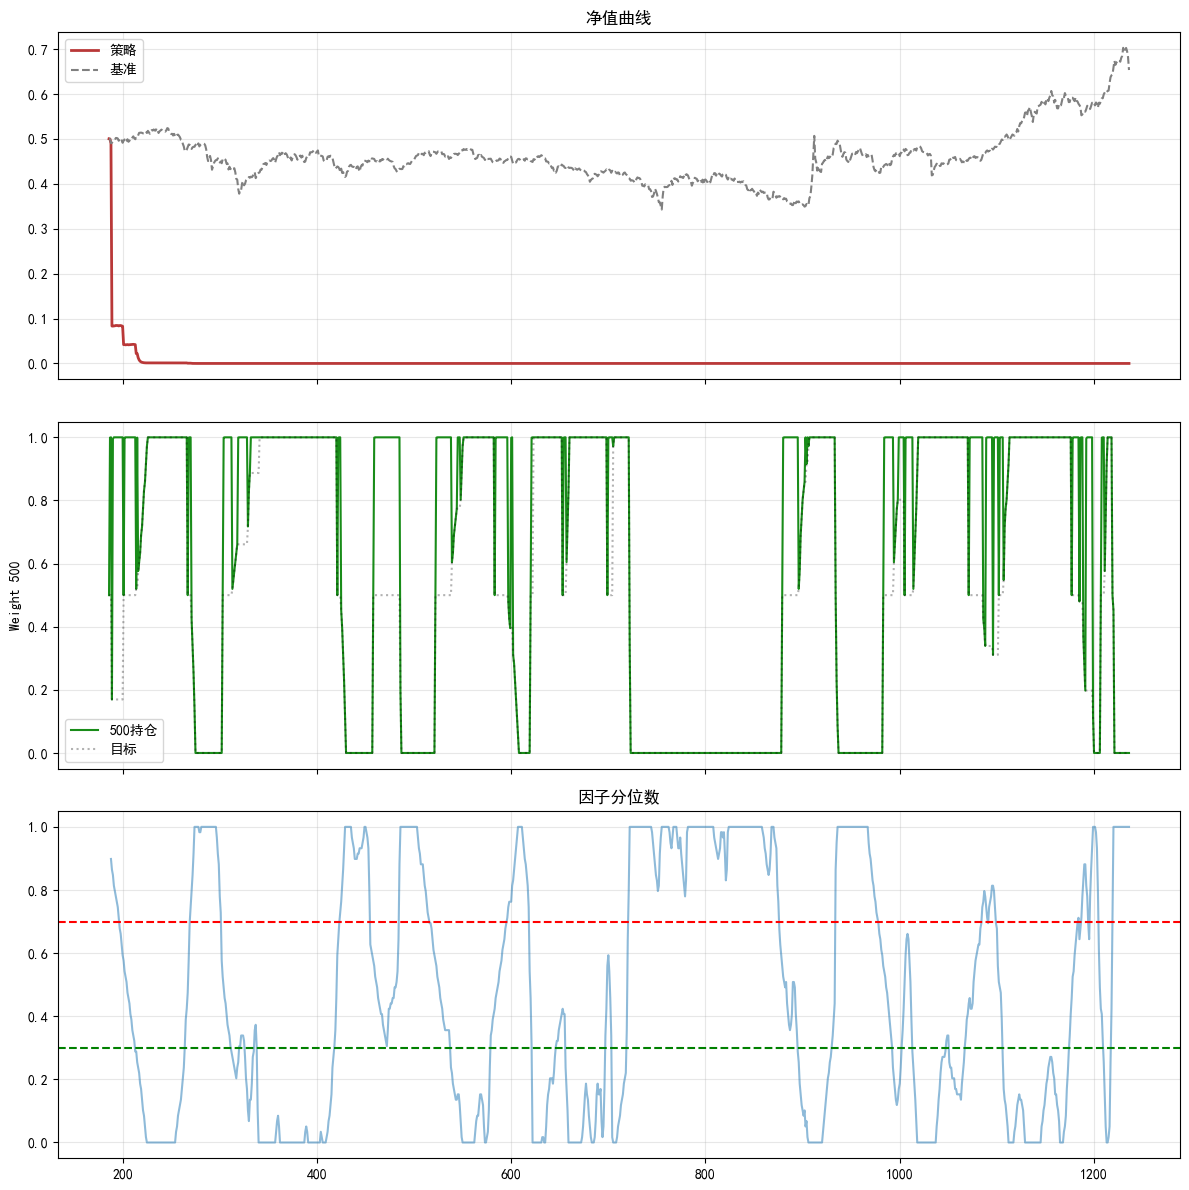

In [350]:
def analyze_performance(df_bt):
    days = len(df_bt)
    ann_ret = (df_bt['Strat_Cum'].iloc[-1] / df_bt['Strat_Cum'].iloc[0]) ** (252 / days) - 1
    bench_ann = (df_bt['Bench_Cum'].iloc[-1] / df_bt['Bench_Cum'].iloc[0]) ** (252 / days) - 1
    mdd = (df_bt['Strat_Cum'] / df_bt['Strat_Cum'].cummax() - 1).min()
    excess = ann_ret - bench_ann
    avg_turnover = df_bt['Turnover'].mean()

    print("\n" + "=" * 50)
    print(f"🏆 最终策略绩效报告 (G组参数)")
    print("=" * 50)
    print(f"策略年化: {ann_ret:.2%}")
    print(f"基准年化: {bench_ann:.2%}")
    print(f"超额收益: {excess:.2%}")
    print(f"最大回撤: {mdd:.2%}")
    print(f"日均换手: {avg_turnover:.2%}")
    print(f"Calmar  : {ann_ret / abs(mdd):.2f}")

    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    axes[0].plot(df_bt['Strat_Cum'], label='策略', color="#b93838", lw=2)
    axes[0].plot(df_bt['Bench_Cum'], label='基准', color='gray', ls='--')
    axes[0].set_title('净值曲线')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(df_bt['W_Final'], color='green', alpha=0.9, lw=1.5, label='500持仓')
    axes[1].plot(df_bt['Target_Exec'], color='black', alpha=0.3, ls=':', label='目标')
    axes[1].set_ylabel('Weight 500')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(df_bt['Factor_Rank'], color='#1f77b4', alpha=0.5, label='Rank')
    axes[2].axhline(LINEAR_HIGH, color='red', ls='--')
    axes[2].axhline(LINEAR_LOW, color='green', ls='--')
    axes[2].set_title('因子分位数')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 保存图表（可选）
    # output_path = os.path.join(OUTPUT_DIR, 'caprot_performance.png')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    # print(f"图表已保存到 {output_path}")

analyze_performance(df_bt)